In [1]:
import numpy as np
import meanderpy as mp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
mpl.rcParams['figure.dpi'] = 500  

In [39]:
def run_meander_simulation(freq_multiplier, amplitude, multiplier):
    nit = 1001               
    W = 100.0                 
    D = 1.0                  
    depths = D * np.ones((nit,))
    pad = 50
    deltas = 100.0
    Cfs = 0.006 * np.ones((nit,))
    crdist = 10 * multiplier * W
    kl = 500.0 / (365 * 24 * 60 * 60.0) 
    kv = 1.0e-12
    dt = 0.1 * 0.5 * 365 * 24 * 60 * 60.0
    dens = 1000
    saved_ts = 1                
    Sl = 0.0
    t1, t2, t3 = 0, 0, 0
    aggr_factor = 2e-19
    x_initial = np.linspace(0.1, 20000, 3000)
    y_initial = (amplitude * 100) * np.sin(freq_multiplier * np.pi * x_initial / 1000.0)
    z_initial = np.zeros_like(x_initial)
    
    ch = mp.Channel(x_initial, y_initial, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])
    chb.migrate(nit, saved_ts, deltas, pad, crdist, depths, Cfs, kl, kv, dt, dens, t1, t2, t3, aggr_factor)
    return chb

In [40]:
def resample_channel(x, y, num_points=10000):
    dx = np.diff(x)
    dy = np.diff(y)
    ds = np.sqrt(dx**2 + dy**2)
    s = np.concatenate(([0], np.cumsum(ds)))
    s_resampled = np.linspace(0, s[-1], num_points)
    x_resampled = interp1d(s, x, kind='linear')(s_resampled)
    y_resampled = interp1d(s, y, kind='linear')(s_resampled)
    return x_resampled, y_resampled

def compute_lyapunov_exponent_resampled_per_node(chb1, chb2):
    n_saved = min(len(chb1.channels), len(chb2.channels))
    num_nodes = 10000  
    distances_2D = np.zeros((num_nodes, n_saved))
    for t_idx in range(n_saved):
        x1, y1 = chb1.channels[t_idx].x, chb1.channels[t_idx].y
        x2, y2 = chb2.channels[t_idx].x, chb2.channels[t_idx].y
        x1_res, y1_res = resample_channel(x1, y1, num_points=num_nodes)
        x2_res, y2_res = resample_channel(x2, y2, num_points=num_nodes)
        node_distances = np.sqrt((x1_res - x2_res)**2 + (y1_res - y2_res)**2)
        distances_2D[:, t_idx] = node_distances
    return distances_2D

In [41]:
perturbation = 1+(1e-15)
chb1 = run_meander_simulation(1, 1, 1)
chb2 = run_meander_simulation(1, perturbation, 1)

100%|██████████| 1001/1001 [00:04<00:00, 217.76it/s]


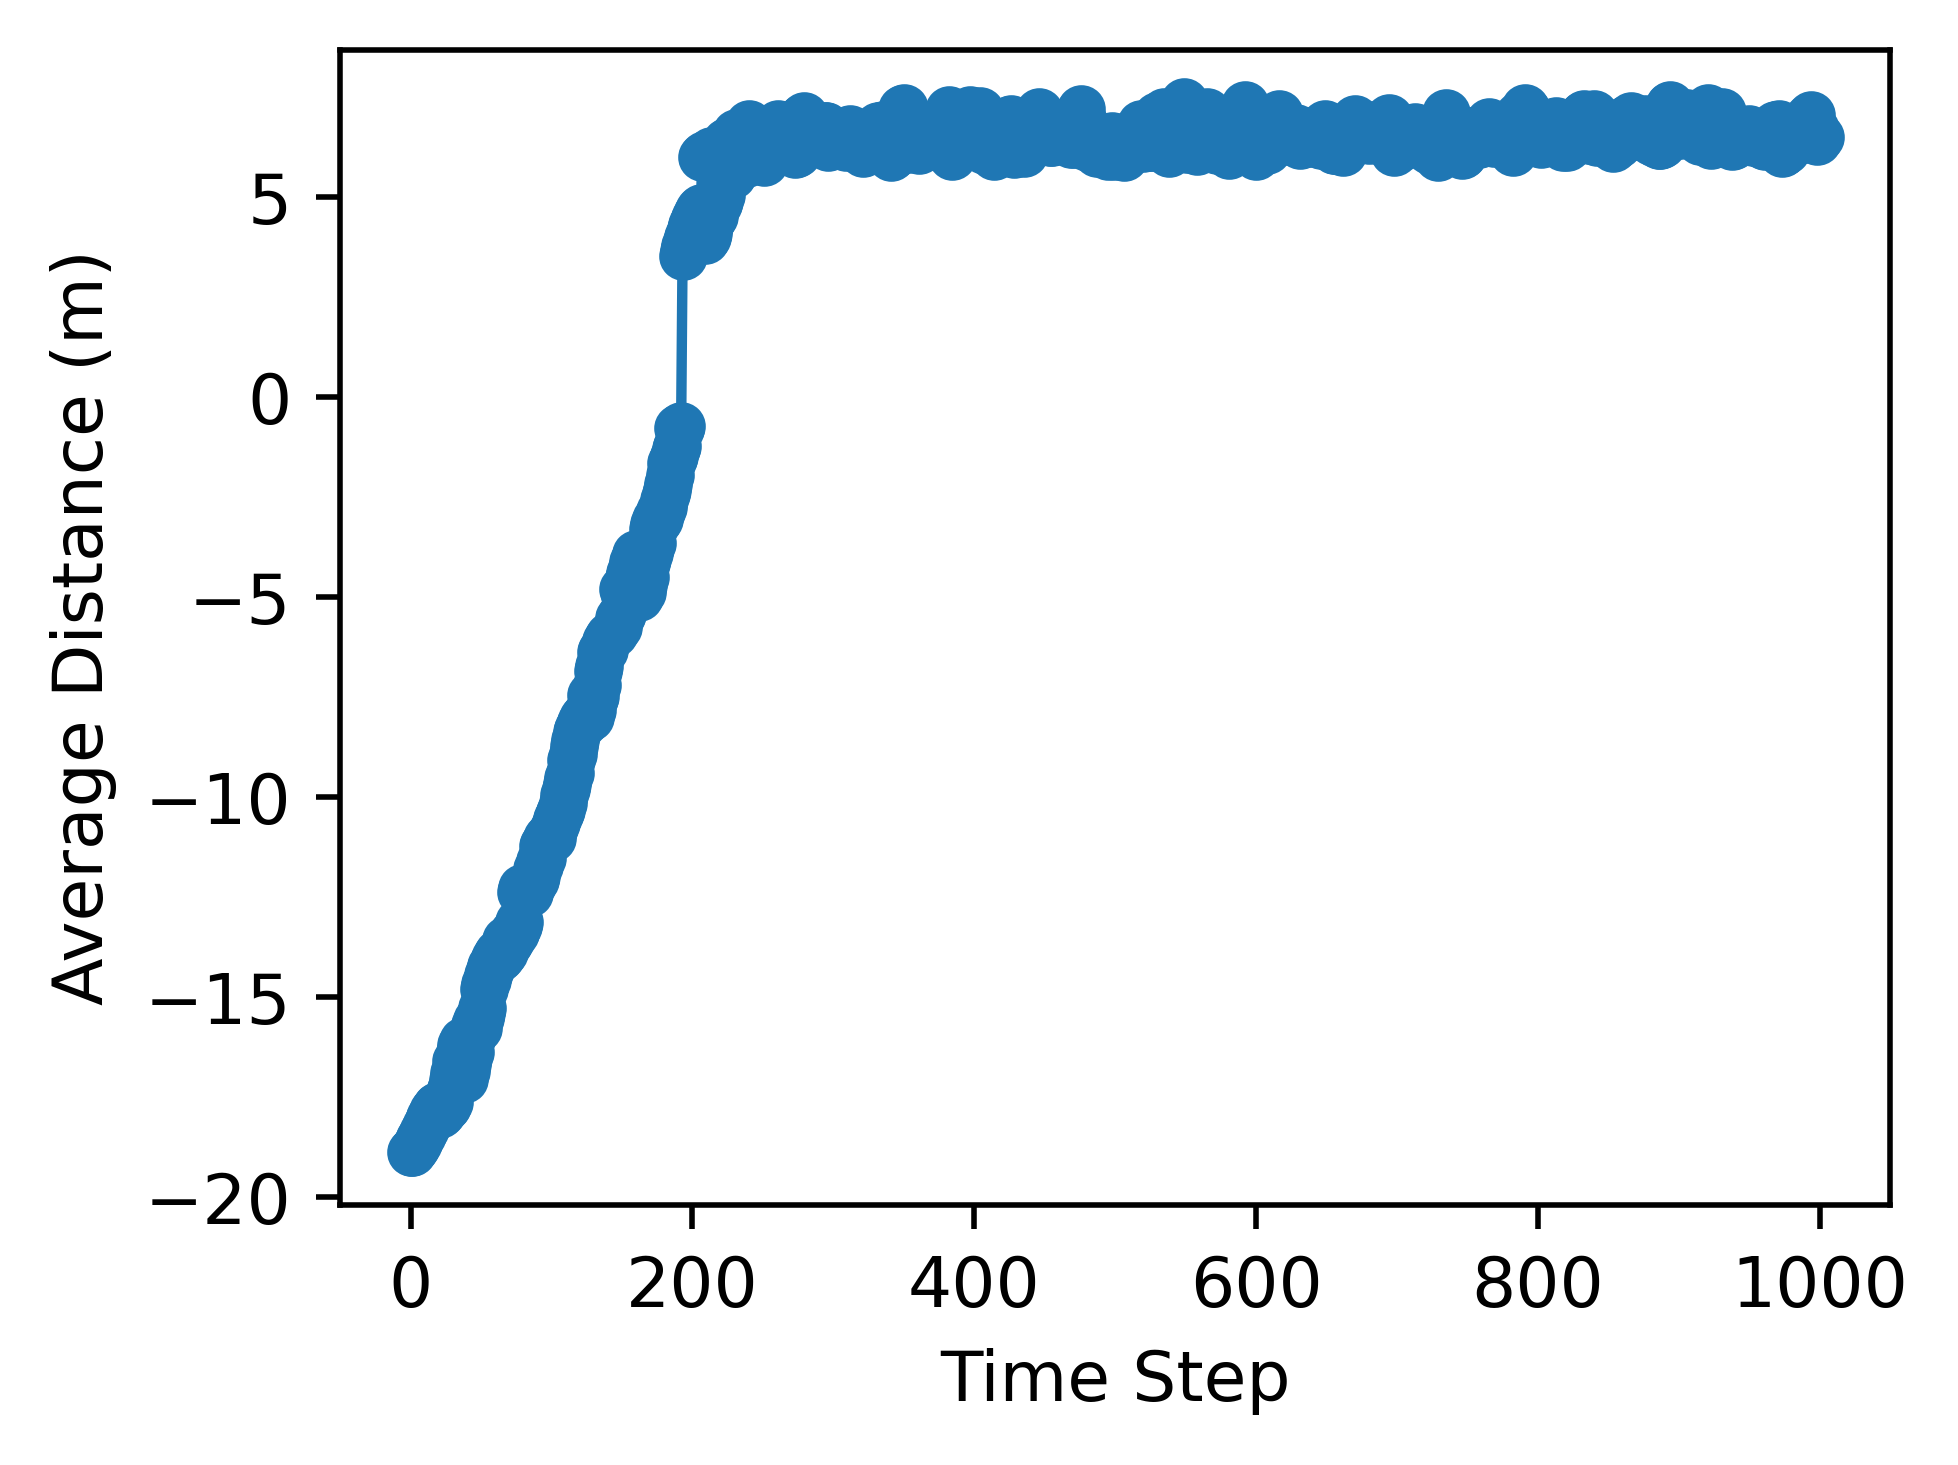

In [44]:
avg_distance_over_time = distances_2D.mean(axis=0) 
time_steps = np.arange(avg_distance_over_time.size)
plt.figure(figsize=(4,3))
plt.plot(time_steps, np.log(avg_distance_over_time), marker='o')
plt.xlabel("Time Step")
plt.ylabel("Average Distance (m)")
plt.show()

Top 10 nodes with highest slopes (time steps 10..190):
Rank 1: Node 3538, slope = 0.103413
Rank 2: Node 3539, slope = 0.103403
Rank 3: Node 3540, slope = 0.103401
Rank 4: Node 3088, slope = 0.103399
Rank 5: Node 3541, slope = 0.103399
Rank 6: Node 3087, slope = 0.103398
Rank 7: Node 3537, slope = 0.103398
Rank 8: Node 3089, slope = 0.103397
Rank 9: Node 3542, slope = 0.103395
Rank 10: Node 3090, slope = 0.103388


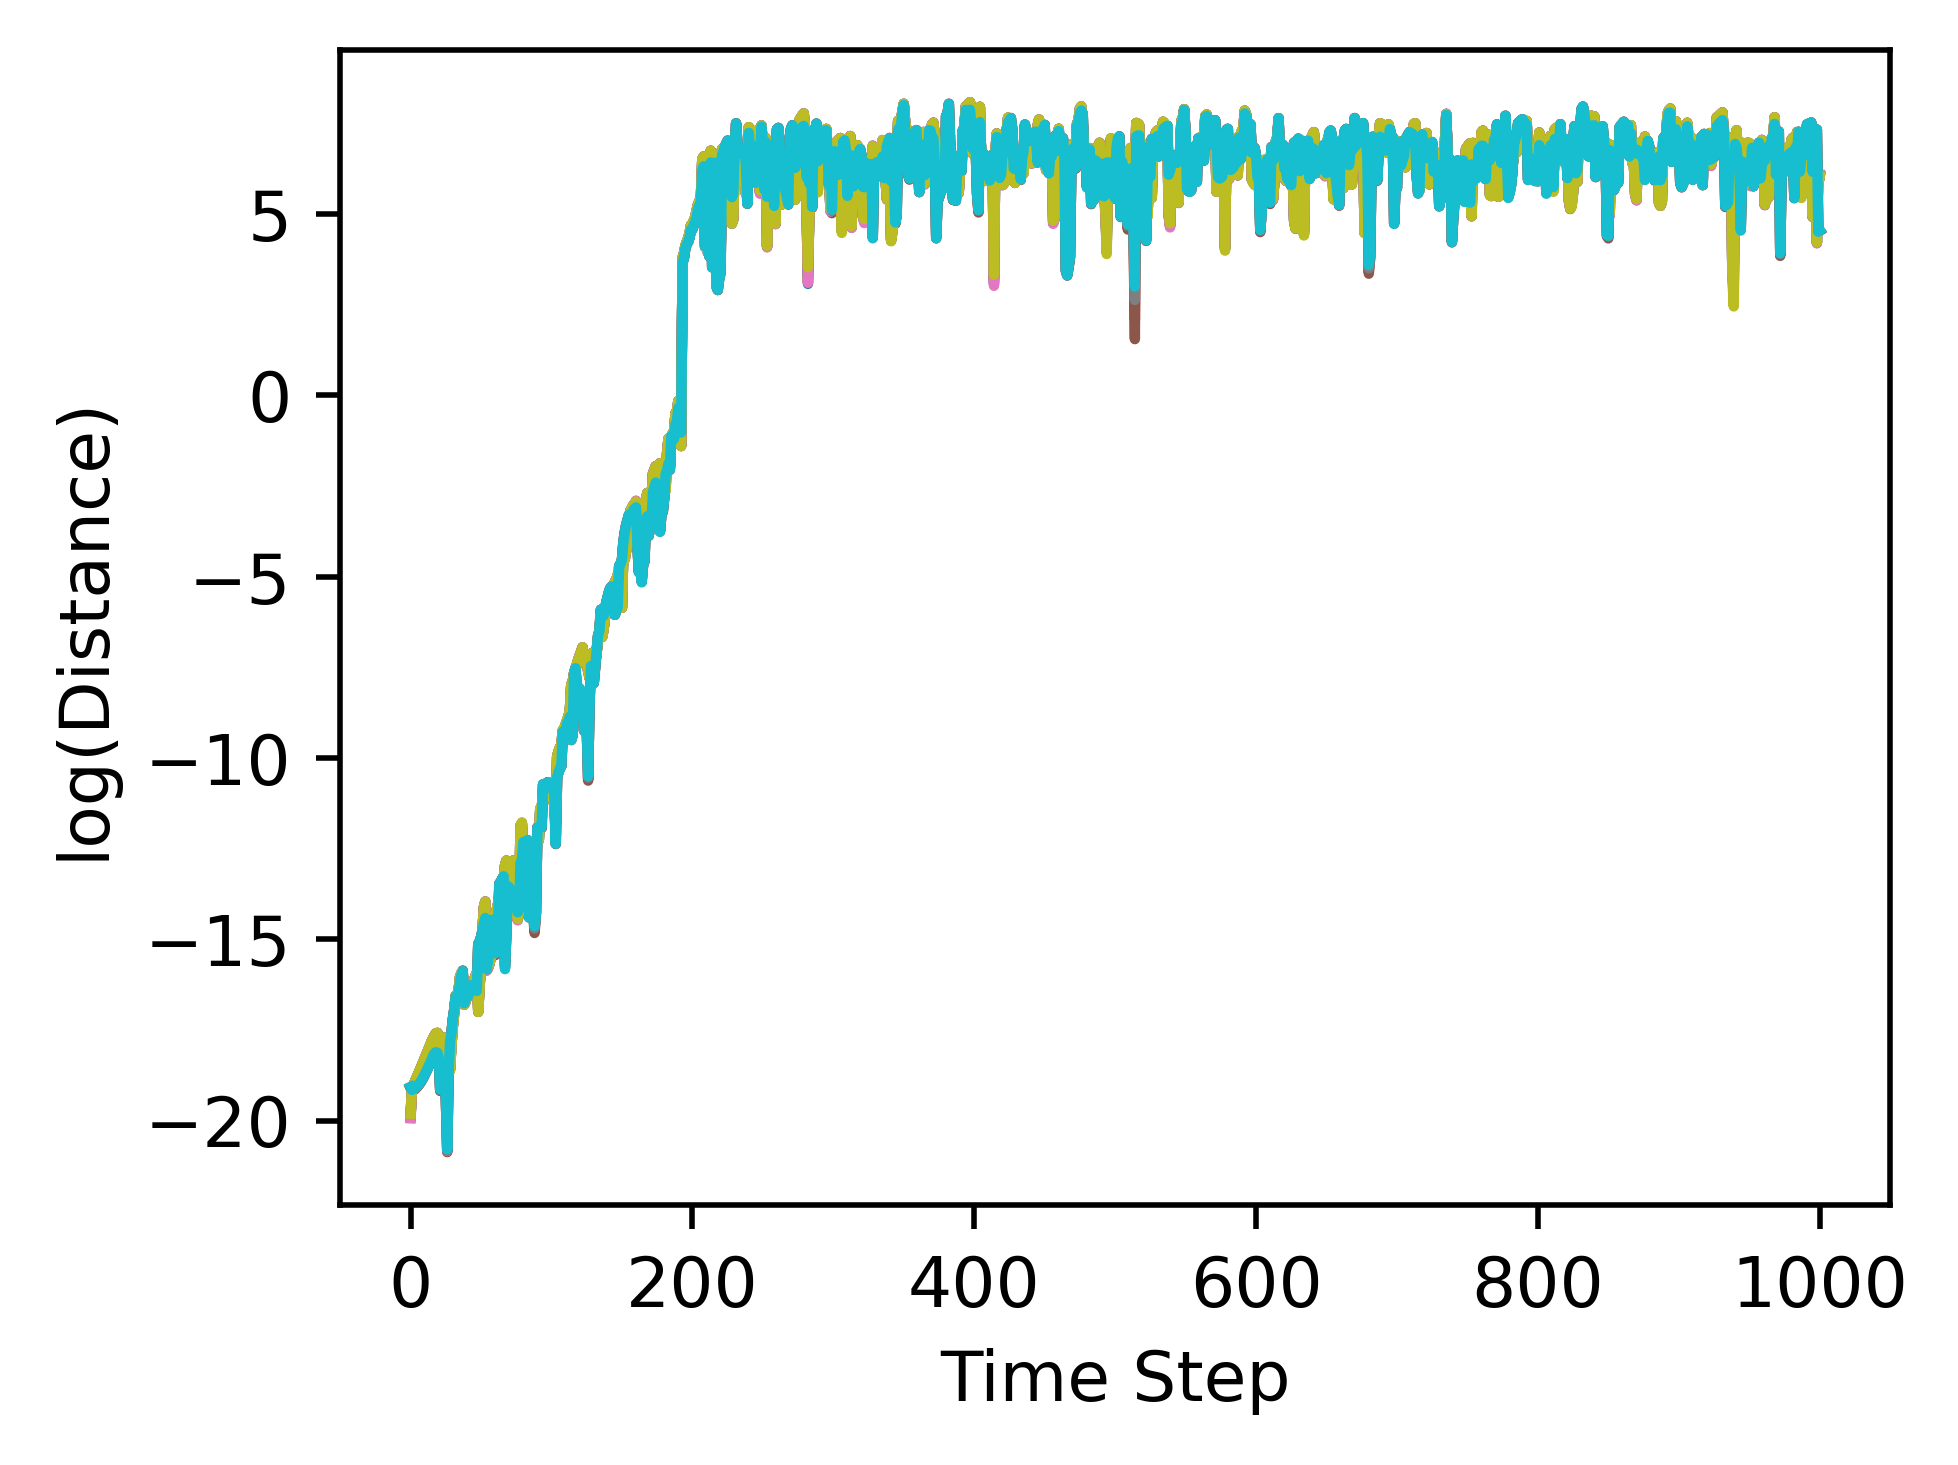

In [48]:
num_top_nodes = 10      
start_idx_fit = 10        
end_idx_fit = 190    
start_idx_plot = 0      
end_idx_plot = 1000
num_nodes, n_times = distances_2D.shape
time_sub_fit = np.arange(start_idx_fit, end_idx_fit + 1)
slopes = np.zeros(num_nodes)

for i in range(num_nodes):
    node_dist = distances_2D[i, start_idx_fit:end_idx_fit+1]
    log_dist = np.log(node_dist)
    slope, intercept = np.polyfit(time_sub_fit, log_dist, 1)
    slopes[i] = slope

sorted_indices_desc = np.argsort(slopes)[::-1]
top_indices_desc = sorted_indices_desc[:num_top_nodes]
top_slopes_desc = slopes[top_indices_desc]
print(f"Top {num_top_nodes} nodes with highest slopes (time steps {start_idx_fit}..{end_idx_fit}):")
for rank, (idx, s) in enumerate(zip(top_indices_desc, top_slopes_desc), start=1):
    print(f"Rank {rank}: Node {idx}, slope = {s:.6f}")
time_sub_plot = np.arange(start_idx_plot, end_idx_plot + 1)

plt.figure(figsize=(4,3))
for i in top_indices_desc:
    dist_sub = distances_2D[i, start_idx_plot:end_idx_plot+1]
    plt.plot(time_sub_plot, np.log(dist_sub), label=f'Node {i}')

plt.xlabel('Time Step')
plt.ylabel('log(Distance)')
plt.show()

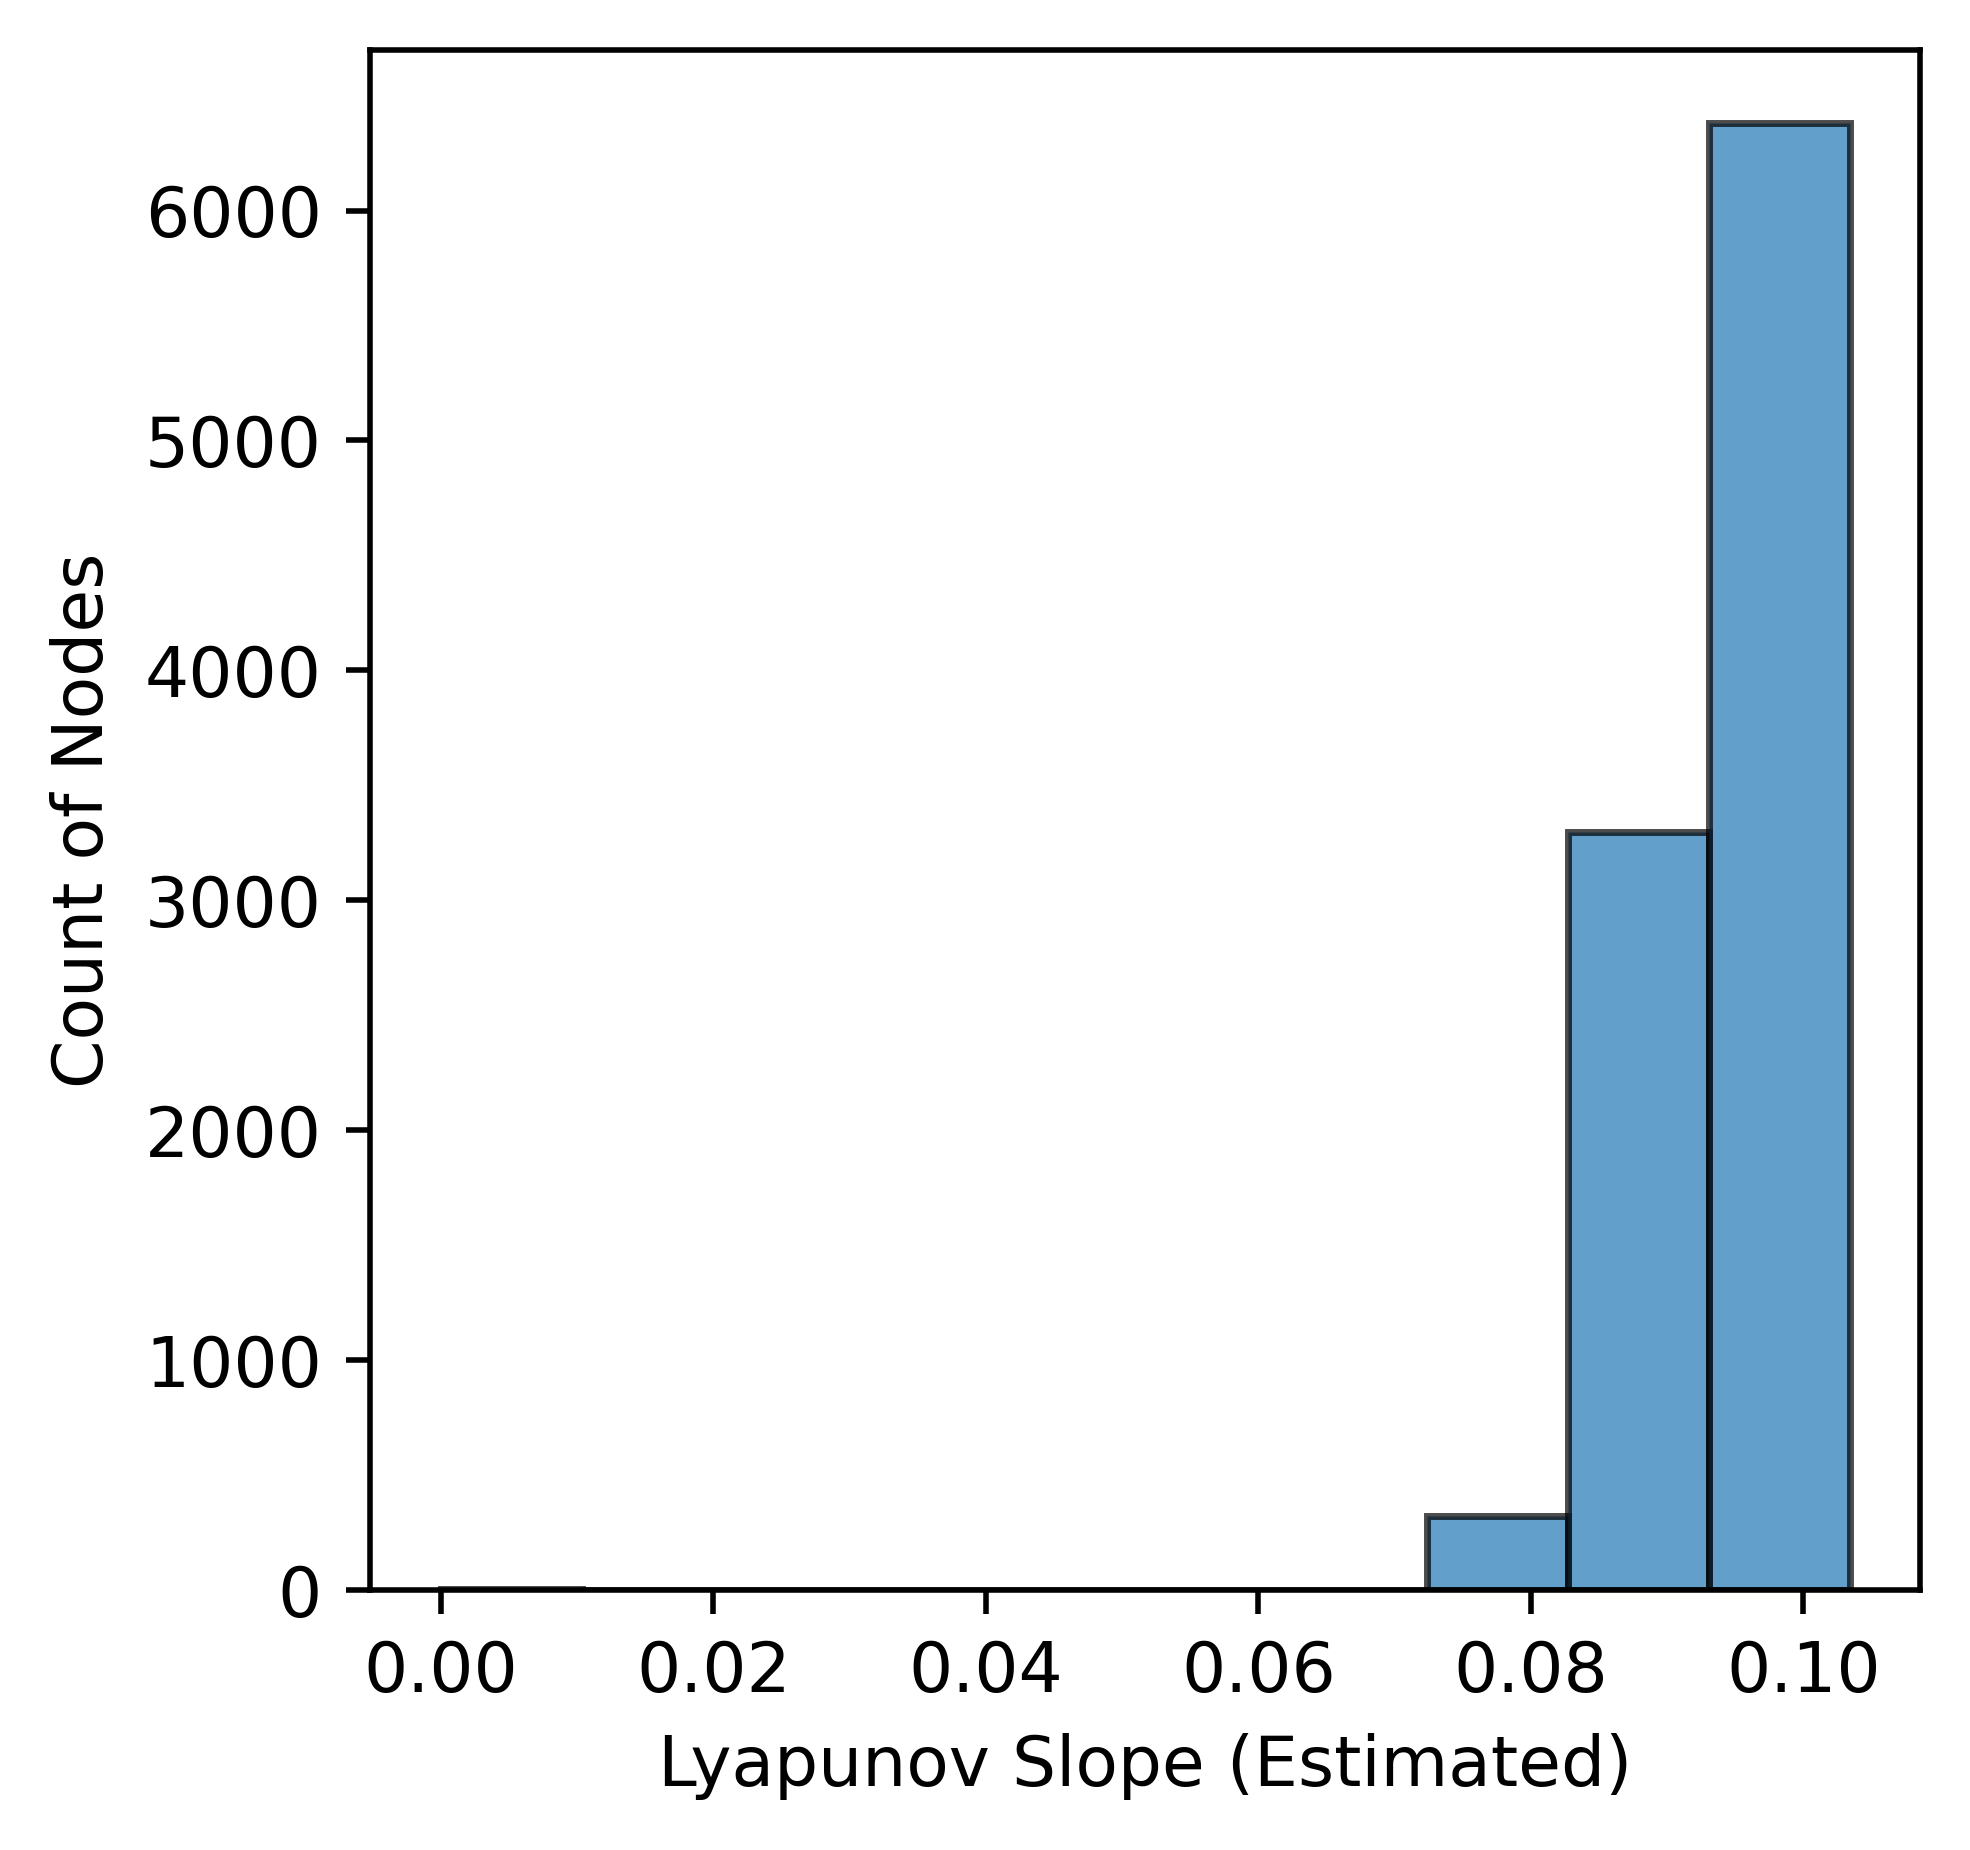

In [49]:
plt.figure(figsize=(4,4))
plt.hist(slopes, bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Lyapunov Slope (Estimated)')
plt.ylabel('Count of Nodes')
plt.show()

Saved distance data for node 3538 (highest slope = 0.103413) to /Users/braydennoh/Documents/phasespace/2.24/lyapunov/1e-15.txt


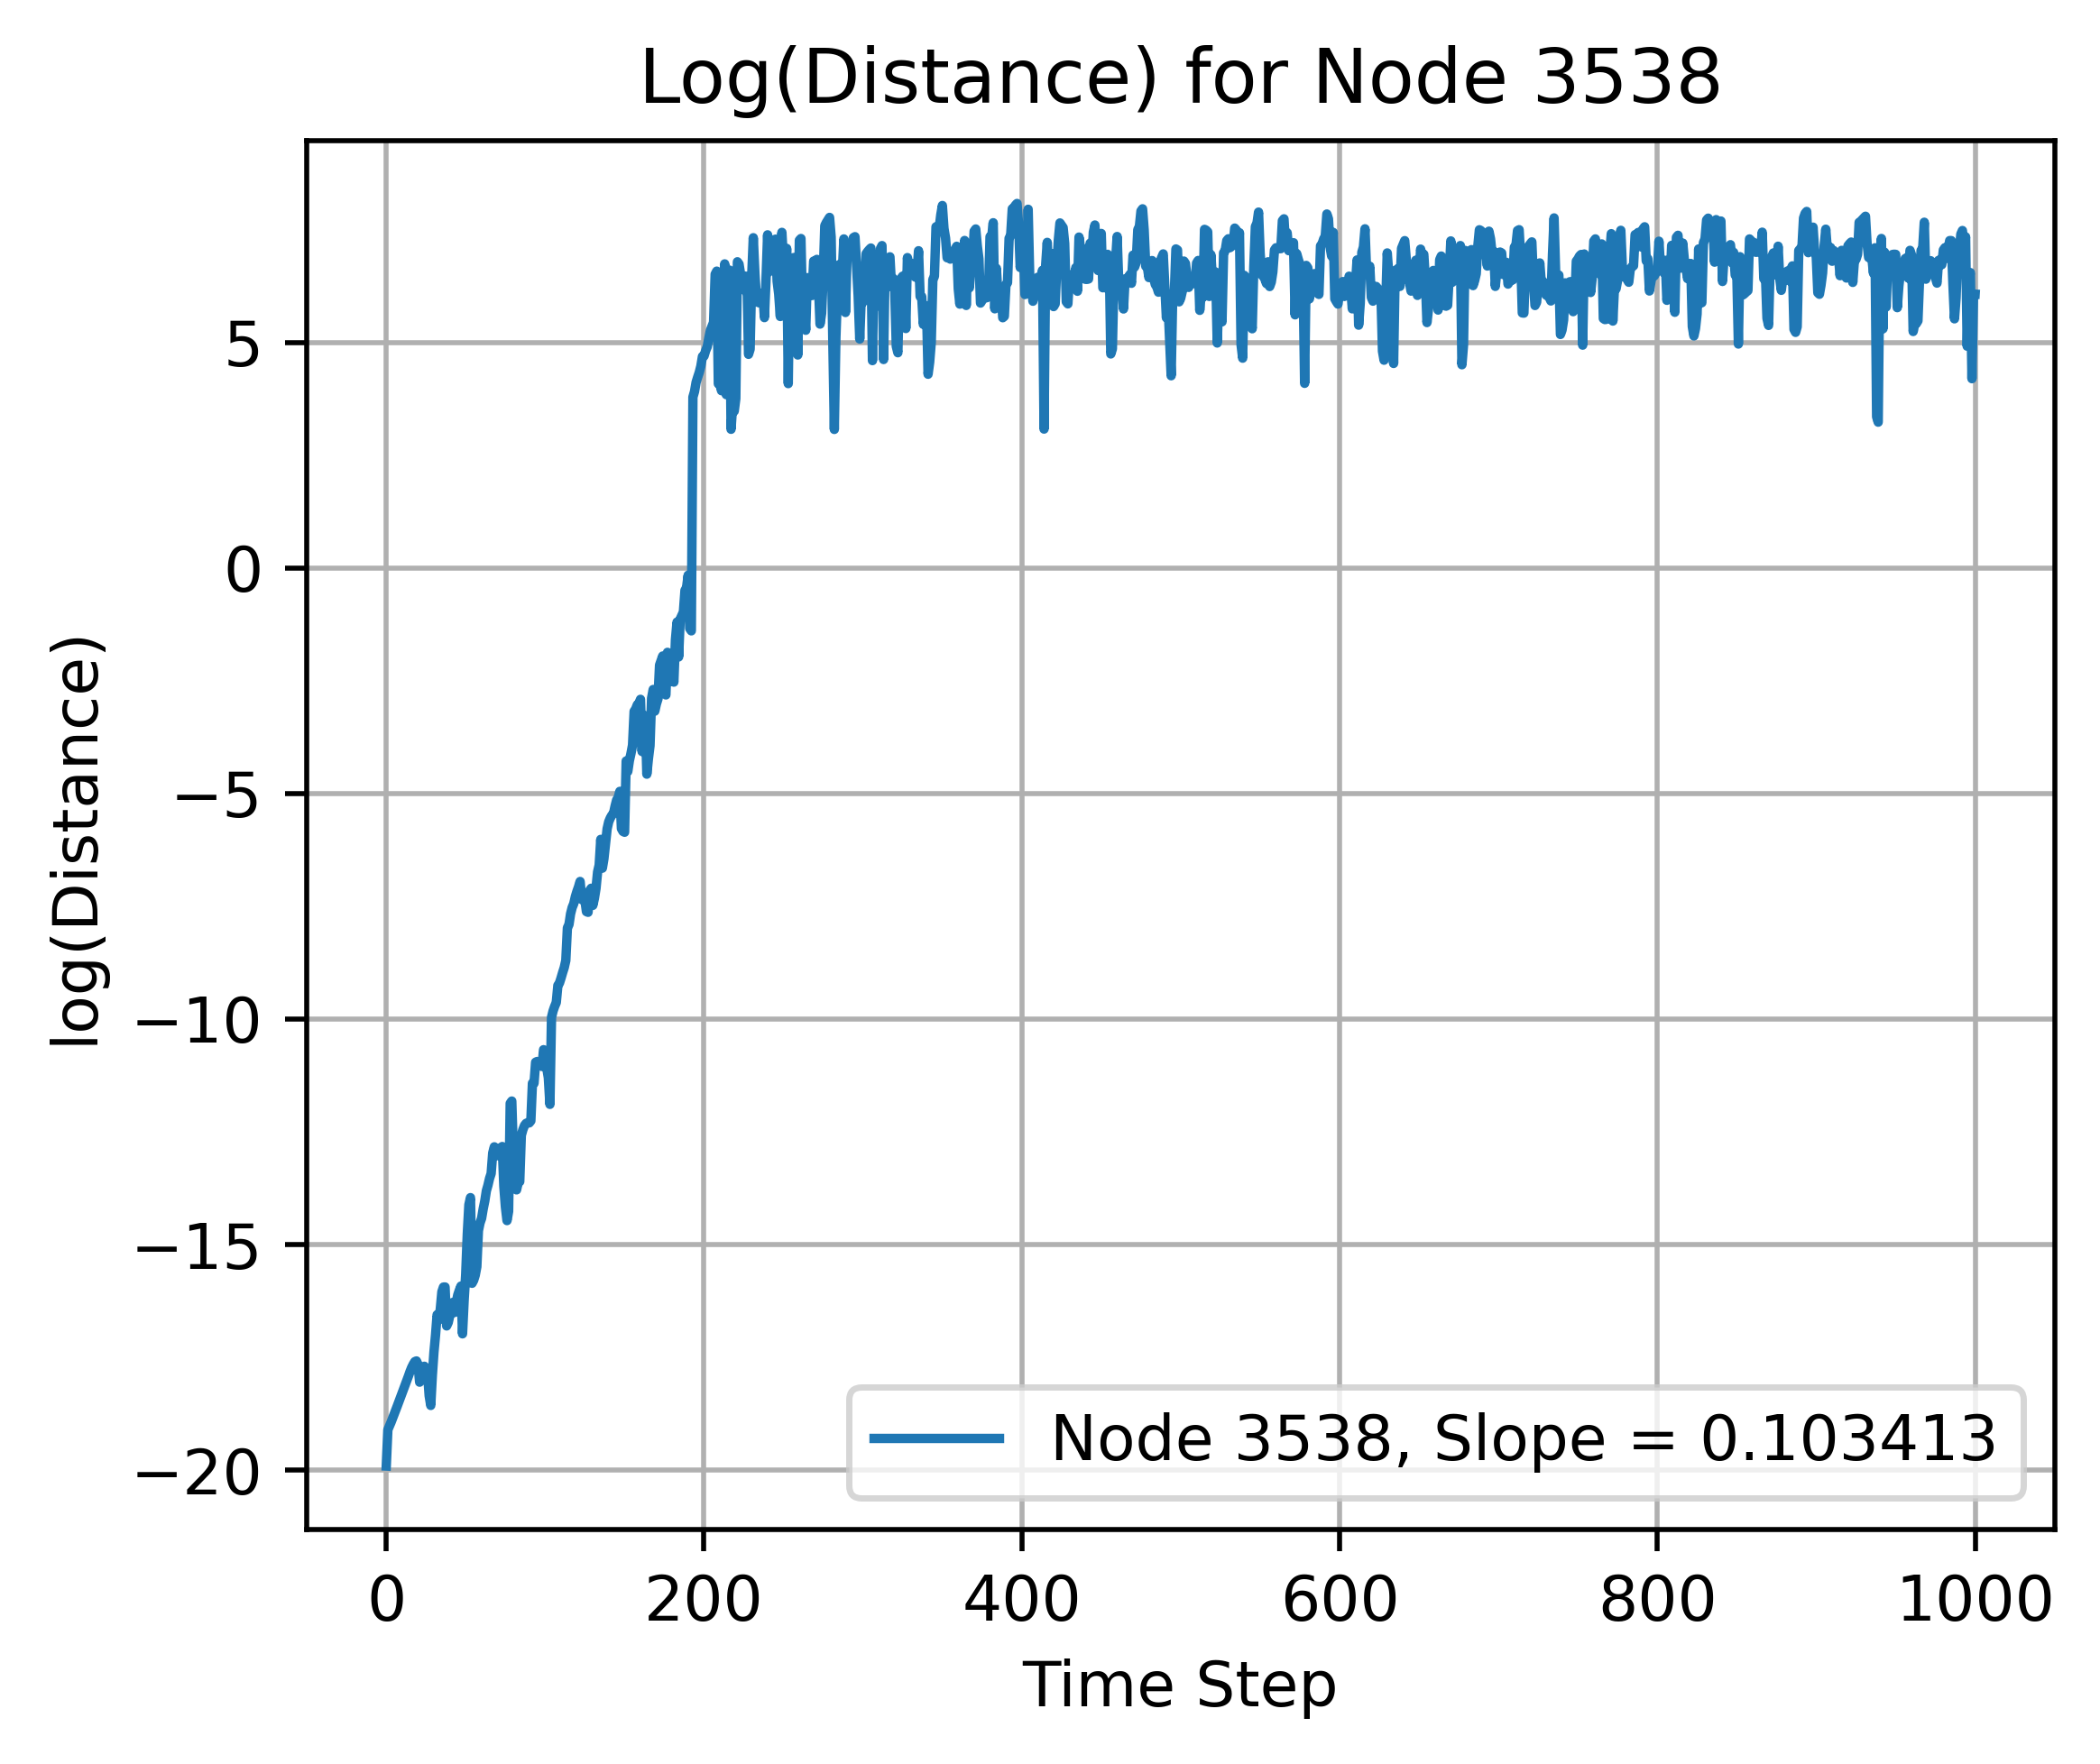

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os

num_top_nodes = 10       # How many top nodes to extract/plot
start_idx_fit = 10       # Start time index for slope fitting
end_idx_fit = 190        # End time index (inclusive) for slope fitting
start_idx_plot = 0       # Start time index for plotting log(d)
end_idx_plot = 1000      # End time index (inclusive) for plotting log(d)

save_path = "/Users/braydennoh/Documents/phasespace/2.24/lyapunov/"
filename = "1e-15.txt"
full_path = os.path.join(save_path, filename)
os.makedirs(save_path, exist_ok=True)
num_nodes, n_times = distances_2D.shape
time_sub_fit = np.arange(start_idx_fit, end_idx_fit + 1)
slopes = np.zeros(num_nodes)

for i in range(num_nodes):
    node_dist = distances_2D[i, start_idx_fit:end_idx_fit+1]
    log_dist = np.log(node_dist)
    slope, intercept = np.polyfit(time_sub_fit, log_dist, 1)
    slopes[i] = slope

max_slope_idx = np.argmax(slopes)
max_slope = slopes[max_slope_idx] 
time_sub_plot = np.arange(start_idx_plot, end_idx_plot + 1)
distance_over_time = distances_2D[max_slope_idx, start_idx_plot:end_idx_plot+1]
np.savetxt(full_path, distance_over_time, fmt="%.6e")
print(f"Saved distance data for node {max_slope_idx} (highest slope = {max_slope:.6f}) to {full_path}")
plt.figure(figsize=(5, 4))
plt.plot(time_sub_plot, np.log(distance_over_time), label=f'Node {max_slope_idx}, Slope = {max_slope:.6f}')
plt.xlabel('Time Step')
plt.ylabel('log(Distance)')
plt.title(f'Log(Distance) for Node {max_slope_idx}')
plt.legend()
plt.grid(True)
plt.show()